# Genome Scale 13C MFA w/ iAF1260 + imEco726 model
Tyler W. H. Backman

To-do
* Need to debug poor fit to fdp MDV, possibly need more samples, or do comparison to core model results to see if biomass constraint is causing problems?

Done:
* Confirmed that 1st carbon in glucose is the one thrown of as CO2 in GND, using imEco726 transitions (e.g. atom ordering is what we expect)
* Compute the set of currency metabolites that pass through reactions in imEco726, but are excluded from the transitions- and excluding these when considering which reactions are carbon carrying and need transitions
* fix some of the guessed transitions, where reshuffling is possible

In [1]:
%matplotlib inline

In [2]:
type(True)

bool

In [3]:
# With Intel Distribution for Python restricting to one core speeds things up ~2x
import os
os.environ['OMP_NUM_THREADS'] = '2'

In [4]:
import bayflux
import cobra
import re
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
import math
from cobra.medium import minimal_medium
from os import path
from Levenshtein import distance
from copy import copy
import itertools

In [5]:
matplotlib.rcParams['figure.figsize'] = (16,8)

In [6]:
# setup options
dataDir = 'input_data'
sbmlFile = path.join(dataDir, 'iAF1260.xml') # iAF1260 downloaded from BiGG on 10/25/2018
transitionsFile = path.join(dataDir, 'imEco726_transitions.csv')
symmetryFile = path.join(dataDir, 'imEco726_symmetry.csv')
labelingDataFile = path.join(dataDir, 'Toya2010_2S', 'wt5h', 'GCMSwt5h.txt')
labelingDataErrorFile = path.join(dataDir, 'Toya2010_2S', 'wt5h', 'GCMSerrwt5h.txt')

### Load input files

In [7]:
cobrapymodel = cobra.io.read_sbml_model(sbmlFile)
model = bayflux.ReactionNetwork(cobrapymodel)
model

Name,iAF1260
Memory address,0x07f436a225f98
Number of metabolites,1668
Number of reactions,2382
Objective expression,-1.0*BIOMASS_Ec_iAF1260_core_59p81M_reverse_3925e + 1.0*BIOMASS_Ec_iAF1260_core_59p81M
Compartments,"cytosol, periplasm, extracellular space"


In [8]:
# Load transitions from Saratram Gopalakrishnan and Costas D. Maranas (2015), "13C metabolic flux analysis at a genome-scale," Metabolic Engineering, Available online 8 September 2015, ISSN 1096-7176. 
# Note this file is unmodified, but exported from Excel as a CSV

transitionsDF = pd.read_csv(transitionsFile)
transitionsDF.head(5)

,maps,startNodeSymbol,metabAbbreviation,ReactantProductFlag,OriginalEquation,rxnAbbreviation,source
0,"1,2,3",C,ala-L[c],reactant,[c] : ala-L <==> ala-D,ALAR,iAF1260
1,"1,2,3",C,ala-D[c],product,[c] : ala-L <==> ala-D,ALAR,iAF1260
2,"1,2,3,4,5",C,akg[c],product,[c] : akg + ala-L <==> glu-L + pyr,ALATA_L,iAF1260
3,"6,7,8",C,ala-L[c],product,[c] : akg + ala-L <==> glu-L + pyr,ALATA_L,iAF1260
4,"1,2,3,4,5",C,glu-L[c],reactant,[c] : akg + ala-L <==> glu-L + pyr,ALATA_L,iAF1260


In [9]:
# load symmetry data from Saratram Gopalakrishnan and Costas D. Maranas (2015), "13C metabolic flux analysis at a genome-scale," Metabolic Engineering, Available online 8 September 2015, ISSN 1096-7176. 
# Note this file is unmodified, but exported from Excel as a CSV

symmetryDF = pd.read_csv(symmetryFile)
symmetryDF

,Metab_name,default mapping,symmetry mapping
0,succ[c],1 2 3 4,4 3 2 1
1,fum[c],1 2 3 4,4 3 2 1
2,phe-L[c],1 2 3 4 5 6 7 8 9,1 2 3 4 9 8 7 6 5
3,tyr-L[c],1 2 3 4 5 6 7 8 9,1 2 3 4 9 8 7 6 5
4,26dap-LL[c],1 2 3 4 5 6 7,7 6 5 4 3 2 1
5,ptrc[c],1 2 3 4,4 3 2 1


In [10]:
# parse 13C labeling data

labelingData = pd.read_csv(labelingDataFile, delim_whitespace=True, skiprows=[0, 1], header=None, index_col=0, usecols=[0] + list(range(2,10)), na_values='-')
labelingData.index = [m.replace('-', '__') + '_c' for m in labelingData.index]
labelingData

,2,3,4,5,6,7,8,9
fdp_c,0.381,0.244,0.081,0.116,0.041,0.017,0.119,NaN
dhap_c,0.584,0.165,0.094,0.157,NaN,NaN,NaN,NaN
3pg_c,0.636,0.173,0.038,0.153,NaN,NaN,NaN,NaN
pep_c,0.624,0.165,0.060,0.151,NaN,NaN,NaN,NaN
pyr_c,0.636,0.165,0.055,0.145,NaN,NaN,NaN,NaN
ru5p__D_c,0.554,0.143,0.108,0.103,0.021,0.071,NaN,NaN
r5p_c,0.537,0.138,0.102,0.124,0.021,0.078,NaN,NaN
s7p_c,0.332,0.197,0.164,0.127,0.073,0.071,0.026,0.01
mal__L_c,0.454,0.252,0.181,0.095,0.018,NaN,NaN,NaN


In [11]:
# convert 13C labeling data into dict format
m = {m.id:m for m in model.metabolites}

lcmsResults = {}
for metaboliteName, labeling in labelingData.iterrows():
    
    # extract non-nan values from mass distribution
    labelingList = list(filter(lambda x: not np.isnan(x), labeling))
    
    # create EMU object from metabolite name and size
    carbonRange = list(range(0, len(labelingList) - 1))
    emuObject = bayflux.EMU(m[metaboliteName],carbonRange)
    
    # save results into dict
    lcmsResults[emuObject] = labelingList

lcmsResults

{fdp_c[1, 2, 3, 4, 5, 6]: [0.381,
  0.244,
  0.081,
  0.11599999999999999,
  0.040999999999999995,
  0.017,
  0.11900000000000001],
 dhap_c[1, 2, 3]: [0.584, 0.165, 0.094, 0.157],
 3pg_c[1, 2, 3]: [0.636, 0.17300000000000001, 0.038, 0.153],
 pep_c[1, 2, 3]: [0.624, 0.165, 0.06, 0.151],
 pyr_c[1, 2, 3]: [0.636, 0.165, 0.055, 0.145],
 ru5p__D_c[1, 2, 3, 4, 5]: [0.5539999999999999,
  0.14300000000000002,
  0.10800000000000001,
  0.10300000000000001,
  0.021,
  0.071],
 r5p_c[1, 2, 3, 4, 5]: [0.537, 0.138, 0.102, 0.124, 0.021, 0.078],
 s7p_c[1, 2, 3, 4, 5, 6, 7]: [0.332,
  0.19699999999999998,
  0.16399999999999998,
  0.127,
  0.073,
  0.071,
  0.026000000000000002,
  0.01],
 mal__L_c[1, 2, 3, 4]: [0.45399999999999996,
  0.252,
  0.18100000000000002,
  0.095,
  0.018000000000000002]}

In [12]:
# parse labeling error data

labelingDataError = pd.read_csv(labelingDataErrorFile, delim_whitespace=True, skiprows=[0, 1], header=None, index_col=0, usecols=[0] + list(range(2,10)), na_values='-')
labelingDataError.index = [m.replace('-', '__') + '_c' for m in labelingDataError.index]
labelingDataError

,2,3,4,5,6,7,8,9
fdp_c,0.021,0.006,0.004,0.016,0.003,0.002,0.009,NaN
dhap_c,0.007,0.003,0.006,0.002,NaN,NaN,NaN,NaN
3pg_c,0.005,0.007,0.008,0.005,NaN,NaN,NaN,NaN
pep_c,0.010,0.004,0.009,0.002,NaN,NaN,NaN,NaN
pyr_c,0.009,0.005,0.006,0.004,NaN,NaN,NaN,NaN
ru5p__D_c,0.012,0.010,0.008,0.009,0.002,0.005,NaN,NaN
r5p_c,0.015,0.004,0.010,0.006,0.003,0.010,NaN,NaN
s7p_c,0.020,0.010,0.003,0.009,0.006,0.006,0.011,0.009
mal__L_c,0.007,0.004,0.002,0.001,0.003,NaN,NaN,NaN


In [13]:
# convert 13C error data into dict format

lcmsResultsError = {}
for metaboliteName, labeling in labelingDataError.iterrows():
    
    # extract non-nan values from mass distribution
    labelingList = list(filter(lambda x: not np.isnan(x), labeling))
    
    # create EMU object from metabolite name and size
    carbonRange = list(range(0, len(labelingList) - 1))
    emuObject = bayflux.EMU(m[metaboliteName],carbonRange)
    
    # save results into dict
    lcmsResultsError[emuObject] = labelingList

lcmsResultsError

{fdp_c[1, 2, 3, 4, 5, 6]: [0.021,
  0.006,
  0.004,
  0.016,
  0.003,
  0.002,
  0.009000000000000001],
 dhap_c[1, 2, 3]: [0.006999999999999999, 0.003, 0.006, 0.002],
 3pg_c[1, 2, 3]: [0.005, 0.006999999999999999, 0.008, 0.005],
 pep_c[1, 2, 3]: [0.01, 0.004, 0.009000000000000001, 0.002],
 pyr_c[1, 2, 3]: [0.009000000000000001, 0.005, 0.006, 0.004],
 ru5p__D_c[1, 2, 3, 4, 5]: [0.012,
  0.01,
  0.008,
  0.009000000000000001,
  0.002,
  0.005],
 r5p_c[1, 2, 3, 4, 5]: [0.015, 0.004, 0.01, 0.006, 0.003, 0.01],
 s7p_c[1, 2, 3, 4, 5, 6, 7]: [0.02,
  0.01,
  0.003,
  0.009000000000000001,
  0.006,
  0.006,
  0.011000000000000001,
  0.009000000000000001],
 mal__L_c[1, 2, 3, 4]: [0.006999999999999999, 0.004, 0.002, 0.001, 0.003]}

In [14]:
## compute mean of 13C labeling data
averageError = float(np.mean(list(itertools.chain(*lcmsResultsError.values()))))
averageError

0.007041666666666667

### Match reaction names between model and transitions

In [15]:
# create set of all reaction IDs in iAF1260
modelReactionIds = {r.id for r in model.reactions}
len(modelReactionIds)

2382

In [16]:
# create set of all reaction IDs in imEco726
transitionReactionIds = set(transitionsDF.rxnAbbreviation)
len(transitionReactionIds)

686

In [17]:
# create set of all reactions in imEco726 without exact name matches to iAF1260
reactionIdDifference = transitionReactionIds.difference(modelReactionIds)
len(reactionIdDifference)

70

In [18]:
# list of replacement regexes to apply to each name that doesn't match the model
# Note for reactions ending in _copyN, usually there is a reversible and a non-reversible version
# in this case, I match the reversibility with that provided with the transitions
reactionRegexes = {
    '\(e\)': '_e', # new naming convention for extracellular is _e not (e)
    '^biomass_out$': 'BIOMASS_Ec_iAF1260_core_59p81M', # set biomass name
    '^EX_([a-zA-Z0-9]{3,5})-': 'EX_\\1__', # for amino acid exchanges
    '([DL])-': '\\1_', # for D-lactate reactions
    '^PPK2r$': 'PPK2',
    '^PRASCS$': 'PRASCSi',
    # '^GLCtex$': 'GLCtex_copy1',
    '^GLCtex$': 'GLCtex_copy2', # here we use the non-reversible one so glucose stays a model input
    '^ICHORSi$': 'ICHORS_copy2',
    '^INSt2rpp$': 'INSt2pp_copy2',
    '^URAt2rpp$': 'URAt2pp_copy2',
    '^URIt2rpp$': 'URIt2pp_copy2',
    '^PPKr$': 'PPK',
    '^MICITD$': 'MICITDr',
    '^URIt2pp$': 'URIt2pp_copy1',
    '^URAt2pp$': 'URAt2pp_copy1',
    '^CYTDt2pp$': 'CYTDt2pp_copy1',
    '^VPAMT$': 'VPAMTr',
    '^CYTDt2rpp$': 'CYTDt2pp_copy2',
    '^THMDt2rpp$': 'THMDt2pp_copy2',
    '^THMDt2pp$': 'THMDt2pp_copy1',
    '^INSt2pp$': 'INSt2pp_copy1',
    '^THRAi$': 'THRA',
    '^DHNPA2$': 'DHNPA2r',
}

# define list of reactions in imEco726 we want to exclude, and not map to the model
# note the dil_ reactions are for representing non-steady-state unlabeled metabolite
# pools, which we will not consider at this time
excludeReactions = {'dil_4', 'dil_3', 'dil_6', 'dil_5', 'dil_9', 
                    'dil_16', 'dil_1', 'dil_18', 'CO2_D', 'dil_8', 
                    'dil_23', 'dil_11', 'dil_15', 'dil_22', 'dil_20', 
                    'dil_21', 'dil_24', 'gluc_up', 'dil_12', 'dil_10', 
                    'dil_19', 'dil_7', 'dil_2', 'dil_14', 'gluc_pre', 
                    'dil_17', 'dil_13'}

# apply each regex to each name
rxnNameConverter = {} # dict to store lookup table from imEco726 to iAF1260
for r in reactionIdDifference:
    newname = copy(r)
    for key, value in reactionRegexes.items():
        newname = re.sub(key, value, newname)
    if newname in modelReactionIds:
        rxnNameConverter[r] = newname
        
# also add the intersection to the rxnNameConverter
intersectionLookup = {r: r for r in modelReactionIds.intersection(transitionReactionIds)}
rxnNameConverter = {**rxnNameConverter, **intersectionLookup}

# assert that all keys in rxnNameConverter are valid reaction names in imEco726
assert len(set(rxnNameConverter.keys()).intersection(transitionReactionIds)) == len(rxnNameConverter.keys())

# assert that all values in rxnNameConverter are valid reaction names in iAF1260
assert len(set(rxnNameConverter.values()).intersection(modelReactionIds)) == len(rxnNameConverter.values())

# assert that all reactions in imEco726 have a lookup, or were excluded on purpose
assert len(rxnNameConverter) + len(excludeReactions) == len(transitionReactionIds)

# output the number of reactions that we have transitions lookups for
len(rxnNameConverter)

659

In [19]:
# this code is now commented out, but represents the code that was used to identify the reactionRegexes above
# newdiff was a set of reaction names from imEco726 with no direct matches in iAF1260

# # Use Levenshtein distance to print the best matches for each unknown reaction
# # use only lower case versions to compute distances
# matches = 5

# for r in newdiff:
#     if re.match('^dil_', r): # skip the dil reactions, they don't have similar names
#         continue
        
#     # skip other exchange reactions
#     if r in ('gluc_up', 'CO2_D', 'gluc_pre'):
#         continue
        
#     # get the formula from the transitions    
#     formula = list(transitionsDF['OriginalEquation'][transitionsDF['rxnAbbreviation'] == r])[0]
#     print('searching ', r, ': ', formula)
    
#     rname = r.lower()
    
#     for rxn in (rname, rname + '_copy'):
    
#         # compute and sort distances
#         distances = [[distance(rxn, modelrxn.lower()), modelrxn] for modelrxn in modelReactionNameSet]
#         sortedDistances = sorted(distances, key=lambda x: x[0])[0:5]

#         # print each match and it's reaction in the model
#         for d in sortedDistances:
#             print('\t', d[0], ' ', d[1], ': ', model.reactions.get_by_id(d[1]).reaction)
        
#         print('\t-')

### Match metabolite names between model and transitions

In [20]:
modelMetaboliteIds = {r.id for r in model.metabolites}
len(modelMetaboliteIds)

1668

In [21]:
transitionMetaboliteIds = set(transitionsDF.metabAbbreviation)
len(transitionMetaboliteIds)

595

In [22]:
# print out reactions in the transitions set which don't have IDs in
# the model
metaboliteIdDifference = transitionMetaboliteIds.difference(modelMetaboliteIds)
len(metaboliteIdDifference)

595

In [23]:
# apply each regex to each name
metaboliteNameConverter = {} # dict to store lookup table from imEco726 to iAF1260
excludeMetabolites = set()
for m in metaboliteIdDifference:
    newMetaboliteName = copy(m)
    
    # update compartment to use _c style instead of [c]
    newMetaboliteName = re.sub('\[([a-z])\]$', '_\\1', newMetaboliteName)
    
    # replace - with either __ or _ depending on which exists in the model
    mTwoDashes = re.sub('-', '__', newMetaboliteName)
    if mTwoDashes in modelMetaboliteIds:
        newMetaboliteName = mTwoDashes
    else:
        newMetaboliteName = re.sub('-', '_', newMetaboliteName)
    
    if newMetaboliteName in modelMetaboliteIds:
        metaboliteNameConverter[m] = newMetaboliteName
    else:
        excludeMetabolites.add(m)
 
len(metaboliteNameConverter)

547

In [24]:
# assert that all keys in metaboliteNameConverter are valid metabolites in imEco726
assert len(set(metaboliteNameConverter.keys()).intersection(transitionMetaboliteIds)) == len(metaboliteNameConverter.keys())

# assert that all values in metaboliteNameConverter are valid metabolites in iAF1260
assert len(set(metaboliteNameConverter.values()).intersection(modelMetaboliteIds)) == len(metaboliteNameConverter.values())

# assert that all metabolites in imEco726 have a lookup, or were excluded on purpose
assert len(metaboliteNameConverter) + len(excludeMetabolites) == len(transitionMetaboliteIds)

# output the number of metabolites that we have lookups for
len(metaboliteNameConverter)

547

In [25]:
# output a list of the metabolite names we aren't going to map
print(excludeMetabolites)

{'Thr[d]', 'Phe[d]', 'ala-D[out]', 'Met[d]', 'fum[out]', 'cys-L[out]', 'Glu[d]', 'glu-L[out]', 'urea[out]', 'Leu[d]', 'Tyr[x]', 'Val[x]', 'Tyr[d]', 'Ala[x]', 'ac[out]', 'Ala[d]', 'leu-L[out]', 'Gly[x]', 'pyr[out]', 'co2[out]', 'Val[d]', 'Ser[d]', 'Ile[d]', 'cbl1[out]', 'val-L[out]', 'Gly[d]', 'Phe[x]', '12ppd-R[out]', '4abut[out]', 'Ser[x]', 'ile-L[out]', 'Glu[x]', 'ser-L[out]', 'lac-D[out]', 'ptrc[out]', 'glc-D[pre]', 'etoh[out]', 'co2[x]', 'Thr[x]', 'succ[out]', 'cynt[out]', 'acser[out]', 'glc-D[out]', 'Met[x]', 'Ile[x]', 'Asp[d]', 'Leu[x]', 'Asp[x]'}


In [26]:
# this code is now commented out, but represents the code that was used to identify the metabolite regexes above
# newdiff was a set of metabolite names from imEco726 with no direct matches in iAF1260

# # Use Levenshtein distance to print the best matches for each unknown metabolite
# # use only lower case versions to compute distances
# matches = 5

# for m in newdiff:
#     mname = m.lower()
    
#     print(m)
    
#     # compute and sort distances
#     distances = [[distance(mname, modelid.lower()), modelid] for modelid in modelMetaboliteIds]
#     sortedDistances = sorted(distances, key=lambda x: x[0])[0:5]

#     # print each match and it's reaction in the model
#     for d in sortedDistances:
#         print('\t', d[0], ' ', d[1], ': ', model.metabolites.get_by_id(d[1]))


### Identify reactions where direction doesn't agree between imEco726 and iAF1260, and reverse the direction for the transitions

**Note:** ABUTt2pp is non-reversible and has reactants/products backwards in the imEco726 transitions, but the direction is not backwards in the text, so we're assuming here that that is not a problem

In [27]:
# correct some errors in the transitions

def reverseDirection(rxnName, transitionsDF):
    # swaps the forward and reverse directions for a reaction based on it's name
    transitionsDF.loc[(transitionsDF.rxnAbbreviation == rxnName) & (transitionsDF.ReactantProductFlag == 'reactant'), 'ReactantProductFlag'] = 'temp'
    transitionsDF.loc[(transitionsDF.rxnAbbreviation == rxnName) & (transitionsDF.ReactantProductFlag == 'product'), 'ReactantProductFlag'] = 'reactant'
    transitionsDF.loc[(transitionsDF.rxnAbbreviation == rxnName) & (transitionsDF.ReactantProductFlag == 'temp'), 'ReactantProductFlag'] = 'product'

In [28]:
exchangeNames = {r.id for r in model.exchanges}
reversedReactions = set()

for tReaction, mReaction in rxnNameConverter.items():
    
    # skip exchange reactions
    if mReaction in exchangeNames:
        continue
    
    # get model reaction object by id
    modelReaction = model.reactions.get_by_id(mReaction)
    mReactants = {m.id for m in modelReaction.reactants}
    mProducts = {m.id for m in modelReaction.products}
    
    # get reaction text from transitions
    reactionSubset = transitionsDF[transitionsDF.rxnAbbreviation.isin([tReaction])].iloc[0]
    
    # get subset of transitions data frame for just this reaction
    tReactants = set(transitionsDF.loc[(transitionsDF.rxnAbbreviation == tReaction) & (transitionsDF.ReactantProductFlag == 'reactant'), 'metabAbbreviation'])
    tProducts = set(transitionsDF.loc[(transitionsDF.rxnAbbreviation == tReaction) & (transitionsDF.ReactantProductFlag == 'product'), 'metabAbbreviation'])
    
    # translate ids from imEco726 to iAF1260 ids
    tReactantsTranslated = {metaboliteNameConverter[r] for r in tReactants}
    tProductsTranslated = {metaboliteNameConverter[r] for r in tProducts}
    

    if len(tReactantsTranslated) == len(tReactantsTranslated.intersection(mReactants)):
        # the direction is correct, confirm that products match also
        assert len(tProductsTranslated) == len(tProductsTranslated.intersection(mProducts))
    else:
        # the direction is wrong, confirm this and then reverse the reaction
        assert len(tProductsTranslated) == len(tProductsTranslated.intersection(mReactants))
        assert len(tReactantsTranslated) == len(tReactantsTranslated.intersection(mProducts))
        
        # if we're going to reverse this, confirm that it's also a reversible reaction so we're not changing
        # the chemistry
        if not modelReaction.lower_bound < 0.0:
            print('swapping non-reversible reaction ' + mReaction)
            print('\t model: ' + modelReaction.reaction)
            print('\t transitions: ' + reactionSubset.OriginalEquation)
        
        reversedReactions.add(tReaction)
        reverseDirection(tReaction, transitionsDF)
        
print('reversed the following backwards reactions: ' + repr(reversedReactions))

swapping non-reversible reaction ABUTt2pp
	 model: 4abut_p + h_p --> 4abut_c + h_c
	 transitions: 4abut[p] + h[p] --> 4abut[c] + h[c]
reversed the following backwards reactions: {'SDPTA', 'HSDy', 'PUNP2', 'ORPT', 'AGPR', 'PGAMT', 'PTRCORNt7pp', 'ASAD', 'TYRTA', 'IPPMIa', 'ACOTA', 'SUCFUMtpp', 'GLUR', 'URIDK2r', 'VALTA', 'PYRt2rpp', 'PPK2r', 'SERt2rpp', '12PPDRtpp', 'G3PD2', 'IPPMIb', 'IMPC', 'ABUTt2pp', 'GLYCtpp', 'ALATA_L', 'PHETA1', 'PGMT', 'KARA1', 'ASPTA', 'ACt2rpp', 'DHORTS', 'ILETA', 'CO2tpp', 'AIRC3'}


In [29]:
model.reactions.get_by_id('ABUTt2pp')

Reaction identifier,ABUTt2pp
Name,4-aminobutyrate transport in via proton symport (periplasm)
Memory address,0x07f436c3e42b0
Stoichiometry,4abut_p + h_p --> 4abut_c + h_c 4-Aminobutanoate + H+ --> 4-Aminobutanoate + H+
GPR,b2663
Lower bound,0.0
Upper bound,999999.0


### Define function to deal with symmetric metabolites

In [30]:
# create a dictionary to translate the name of symmetric metabolites
# from the SBML model to the names used in the transitions
symmetricMs = {metaboliteNameConverter[m]: m for m in symmetryDF.Metab_name}
symmetricMs

{'succ_c': 'succ[c]',
 'fum_c': 'fum[c]',
 'phe__L_c': 'phe-L[c]',
 'tyr__L_c': 'tyr-L[c]',
 '26dap_LL_c': '26dap-LL[c]',
 'ptrc_c': 'ptrc[c]'}

In [31]:
def getSymmetry(metaboliteName, atomMappings, symmetryDF=symmetryDF, symmetricMs=symmetricMs):
    # this function takes a metabolite by name from the SBML model
    # and a list of atom indices, and refactors the indicies accordingly
    # to return the symmetric version
    
    # get the metabolite name from the symmetry file
    tMetaboliteName = symmetricMs[metaboliteName]
    
    # get the correct row from the data frame
    symmetryRow = symmetryDF.loc[symmetryDF['Metab_name'] == tMetaboliteName].iloc[0]
    
    # extract the mapping indices
    defaultMapping = [int(i) for i in symmetryRow['default mapping'].split()]
    symmetryMapping = [int(i) for i in symmetryRow['symmetry mapping'].split()]
    
    # create dict mapping default mapping locations to symmetry mapping locations
    # subtract 1 from indices because the Maranas symmetry mappings use 1-index
    map = {}
    for d, s in zip(defaultMapping, symmetryMapping):
        map[d - 1] = s - 1
        
    # use this dict to translate mappings
    newmapping = copy(atomMappings)
    for i, pos in enumerate(atomMappings):
        newmapping[map[i]] = pos
    
    # return the mapped results of the input
    return newmapping

In [32]:
# test out reordering
getSymmetry('succ_c', [1, 2, 3, 4])

[4, 3, 2, 1]

In [33]:
getSymmetry('fum_c', [10, 11, 12, 13])

[13, 12, 11, 10]

### Add atom transitions to model

In [34]:
for tReaction, mReaction in rxnNameConverter.items():
    
    # get model reaction object by id
    modelReaction = model.reactions.get_by_id(mReaction)
    
    # get subset of transitions data frame for just this reaction
    reactionSubset = transitionsDF[transitionsDF.rxnAbbreviation.isin([tReaction])]
    
    # skip this reaction if some of the metabolites can't map to the model
    # note: in practice this should only hit weird metabolites we don't need
    metaboliteNames = set(reactionSubset.metabAbbreviation)
    if not all(m in metaboliteNameConverter.keys() for m in metaboliteNames):
        print('skipping reaction ' + tReaction)
        continue

    # create empty lists to store atom mappings for each metabolite
    reactantLabels = []
    productLabels = []
    
    # loop over rows in transitions data frame for this reaction
    for label, row in reactionSubset.iterrows():
        
        # parse mapping text into a list of integer
        mapping = [int(i) for i in row['maps'].split(',')]
        
        # get the metabolite object from the model for this metabolite
        metaboliteId = row['metabAbbreviation']
        modelMetabolite = model.metabolites.get_by_id(metaboliteNameConverter[metaboliteId])
        
        # add mappings to reactant or product list as appropriate
        if row['ReactantProductFlag'] == 'reactant':
            assert modelMetabolite in modelReaction.reactants, 'mismatch between reactants in model/transitions for rxn ' + \
                mReaction + '/' + tReaction + ' metabolite ' + metaboliteNameConverter[metaboliteId] + '/' + metaboliteId
            reactantLabels.append((modelMetabolite,mapping,))
        else:
            assert modelMetabolite in modelReaction.products, 'mismatch between products in model/transitions for rxn ' + \
                mReaction + '/' + tReaction + ' metabolite ' + metaboliteNameConverter[metaboliteId] + '/' + metaboliteId
            assert row['ReactantProductFlag'] == 'product'
            productLabels.append((modelMetabolite,mapping,))
    
    # create standard transition object
    transitions = [bayflux.AtomTransition(
        tuple(reactantLabels),
        tuple(productLabels)
    )]
    
    # get list of all metabolite IDs in this transition
    metaboliteIdsInTransition = {m[0].id for m in reactantLabels + productLabels}
    
    # identify reactants and products which are symmetric
    symInTransition = metaboliteIdsInTransition.intersection(symmetricMs.keys())
    
    # for every symmetric metabolite, duplicate the list of transitions objects
    # while translating the mappings
    for m in symInTransition:
        newTransitions = []
        for oldTransition in transitions:
            
            reactants = oldTransition.reactants
            products = oldTransition.products
            
            # if a reactant is symmetric create a new list
            if m in {i[0].id for i in reactants}:
                newReactants = []
                for i in reactants:
                    mapping = i[1]
                    
                    # if symmetric, replace with mirror version
                    if i[0].id == m:
                            mapping = getSymmetry(m, i[1])
                    
                    newReactants.append((i[0], mapping,))
                reactants = newReactants
 
            # if a product is symmetric create a new list
            if m in {i[0].id for i in products}:
                newProducts = []
                for i in products:
                    mapping = i[1]
                    
                    # if symmetric, replace with mirror version
                    if i[0].id == m:
                            mapping = getSymmetry(m, i[1])
                    
                    newProducts.append((i[0], mapping,))
                products = newProducts
            
            newTransitions.append(
                bayflux.AtomTransition(
                    tuple(reactants),
                    tuple(products)
                )
            )
        transitions = transitions + newTransitions
    
    # add transitions to model
    modelReaction.transitions = transitions

skipping reaction EX_pyr(e)
skipping reaction EX_urea(e)
skipping reaction EX_lac-D(e)
skipping reaction EX_ala-D(e)
skipping reaction EX_etoh(e)
skipping reaction EX_4abut(e)
skipping reaction EX_val-L(e)
skipping reaction EX_glu-L(e)
skipping reaction EX_acser(e)
skipping reaction EX_12ppd-R(e)
skipping reaction EX_cbl1(e)
skipping reaction EX_cynt(e)
skipping reaction EX_co2(e)
skipping reaction EX_ser-L(e)
skipping reaction EX_fum(e)
skipping reaction EX_succ(e)
skipping reaction EX_ptrc(e)
skipping reaction EX_ile-L(e)
skipping reaction EX_leu-L(e)
skipping reaction EX_ac(e)
skipping reaction EX_cys-L(e)


In [35]:
# check that we're creating symmetric transitions properly
for r in model.metabolites.fum_c.reactions:
    if len(r.transitions) > 0:
        print(r.id + ': ' + repr(r.transitions))

ADSL2r: [25aics_c --> aicar_c + fum_c	abcdefghijklm : abcdefghi + jklm, 25aics_c --> aicar_c + fum_c	abcdefghijklm : abcdefghi + mlkj]
ADSL1r: [dcamp_c --> amp_c + fum_c	abcdefghijklmn : abcdefghij + klmn, dcamp_c --> amp_c + fum_c	abcdefghijklmn : abcdefghij + nmlk]
FUM: [fum_c --> mal__L_c	abcd : abcd, fum_c --> mal__L_c	abcd : dcba]
FUMt2_3pp: [fum_p --> fum_c	abcd : abcd, fum_p --> fum_c	abcd : dcba]
SUCFUMtpp: [fum_p + succ_c --> fum_c + succ_p	abcd + efgh : abcd + efgh, fum_p + succ_c --> fum_c + succ_p	abcd + efgh : abcd + hgfe, fum_p + succ_c --> fum_c + succ_p	abcd + efgh : dcba + efgh, fum_p + succ_c --> fum_c + succ_p	abcd + efgh : dcba + hgfe]
FUMt2_2pp: [fum_p --> fum_c	abcd : abcd, fum_p --> fum_c	abcd : dcba]
SUCDi: [succ_c --> fum_c	abcd : abcd, succ_c --> fum_c	abcd : dcba, succ_c --> fum_c	abcd : dcba, succ_c --> fum_c	abcd : abcd]
ARGSL: [argsuc_c --> arg__L_c + fum_c	abcdefghij : abcdef + ghij, argsuc_c --> arg__L_c + fum_c	abcdefghij : abcdef + jihg]
ASPO5: [asp__L

In [36]:
# count the number of reactions we have transitions for
sum([len(r.transitions) > 0 for r in model.reactions])

638

### Check that the reversibility of all reactions matches

**Note:** mismatches in exchange reactions are fine here, because we aren't using atom transitions for exchanges in jQMM2

In [37]:
for tReaction, mReaction in rxnNameConverter.items():
    
    # True iff model reaction is reversible
    r = model.reactions.get_by_id(mReaction)
    modelR = r.lower_bound < 0.0
    
    # True iff transition reaction is reversible
    reactionSubset = transitionsDF[transitionsDF.rxnAbbreviation.isin([tReaction])].iloc[0]
    transitionR = re.search('<==>', reactionSubset.OriginalEquation) is not None

    # print out all reactions where the directions don't match
    if not (modelR == transitionR):
        print(r.id)
        print('\t model: ' + r.reaction)
        print('\t transitions: ' + reactionSubset.OriginalEquation)

EX_cbl1_e
	 model: cbl1_e <=> 
	 transitions: cbl1[out] --> cbl1[e]
EX_co2_e
	 model: co2_e <=> 
	 transitions: co2[e] --> co2[out]
GLCtex_copy2
	 model: glc__D_e --> glc__D_p
	 transitions: glc-D[e] <==> glc-D[p]


### make all carbon inputs not reversible

In [38]:
model.reactions.get_by_id('CYNTtex').lower_bound = 0.0
model.reactions.get_by_id('CBL1tonex').lower_bound = 0.0

### test 13C labeling simulation

In [39]:
m = {m.id:m for m in model.metabolites}

# experimental carbon labeling data
substrateLabelingDict = {
    m['glc__D_e']: ((0.3, [1,0,0,0,0,0]),(0.2, [1,1,1,1,1,1]),(0.5, [0,0,0,0,0,0]),),
    m['cynt_e']: ((1.0, [0]),),
}

In [40]:
def findInputs(decomposition):
    # takes an EMU decomposition as created w/ bayflux.emuDecomposition and returns
    # all input metabolites, that have no precursors
    
    # useful for debugging 'hanging inputs' that aren't your labled carbon sources
    
    sources = set()
    for t in decomposition:
        for reactant in t.reactants:
            sources.add(reactant)
    for t in decomposition:
        sources.discard(t.product)
    inputMetabolites = {m.metabolite.id for m in sources}
    return inputMetabolites

In [41]:
emusToSimulate = list(lcmsResults.keys())

decomposition = bayflux.emuDecomposition(emusToSimulate)
findInputs(decomposition)

{'cynt_e', 'glc__D_e'}

In [42]:
# EMUs to simulate in list form
emusToSimulate = list(lcmsResults.keys())

# Perform EMU decomposition, and compile results for later EMU simulation
compiledData = bayflux.emuCompile(emusToSimulate, model, substrateLabelingDict)

In [43]:
# test that we can simulate labeling
fluxes = bayflux.FluxVector(model,[0.1 for v in model.variables])
results = bayflux.simulateLabeling(compiledData, fluxes, substrateLabelingDict)

### Set exchange fluxes

In [44]:
model.reactions.EX_glc__D_e.lower_bound = -11.7
model.reactions.EX_glc__D_e.upper_bound = -11.7
model.reactions.BIOMASS_Ec_iAF1260_core_59p81M.lower_bound = 0.83
model.reactions.BIOMASS_Ec_iAF1260_core_59p81M.upper_bound = 0.89
model.reactions.EX_ac_e.lower_bound = 4.3
model.reactions.EX_ac_e.upper_bound = 4.3
model.reactions.GLCtex_copy1.lower_bound = 0
model.reactions.GLCtex_copy1.upper_bound = 0

### Apply minimal media constraints

In [45]:
max_growth = model.slim_optimize()

In [46]:
# identify the smallest set of media components required to support growth

mediaResults = minimal_medium(model, max_growth, minimize_components=True)
mediaResults

EX_ca2_e         0.004216
EX_cl_e          0.004216
EX_cobalt2_e     0.002811
EX_cu2_e         0.002811
EX_fe2_e         0.013046
EX_glc__D_e     11.700000
EX_k_e           0.158064
EX_mg2_e         0.007027
EX_mn2_e         0.002811
EX_mobd_e        0.002811
EX_nh4_e         9.597796
EX_o2_e         18.500000
EX_pi_e          0.855571
EX_so4_e         0.222722
EX_zn2_e         0.002811
dtype: float64

In [47]:
# prevent uptake of all nutrients not required to support growth

for r in model.exchanges:
    if r.id not in mediaResults:
        r.lower_bound = max(0.0, r.lower_bound)

In [48]:
model.optimize()

,fluxes,reduced_costs
12DGR120tipp,0.000000,0.0
12DGR140tipp,0.000000,0.0
12DGR141tipp,0.000000,0.0
12DGR160tipp,0.000000,0.0
12DGR161tipp,0.000000,0.0
...,...,...
ZN2abcpp,0.000000,0.0
ZN2t3pp,0.000000,0.0
ZN2tpp,0.002811,0.0
ZNabcpp,0.000000,0.0


### Apply Toya 2010 media constraints

This updates the above media constraints with data from the Toya 2010 published minimal media composition

In [49]:
toyaMedia = \
    {'EX_ca2_e',
     'EX_cl_e',
     'EX_cobalt2_e',
     'EX_cu2_e',
     'EX_fe2_e',
     'EX_glc__D_e',
     'EX_h2o_e',
     'EX_k_e',
     'EX_mg2_e',
     'EX_mn2_e',
     'EX_mobd_e',
     'EX_na1_e',
     'EX_nh4_e',
     'EX_o2_e',
     'EX_pi_e',
     'EX_zn2_e',
     'EX_so4_e'}

In [50]:
# list media components to add to mediaResultsSet
# these are things that we computed as not absolutely essential, but were in the published media
mediaResultsSet = set(mediaResults.index)
addToMedia = toyaMedia.difference(mediaResultsSet)
addToMedia

{'EX_h2o_e', 'EX_na1_e'}

In [51]:
# list media components to remove from mediaResultsSet
mediaResultsSet.difference(toyaMedia)

set()

In [52]:
# reallow the media components that should be added per addToMedia

for rName in addToMedia:
    r = model.reactions.get_by_id(rName)
    r.lower_bound = -1000.0

### Identify currency metabolites

These are metabolites that occur in reactions but not transitions, and can be excluded
from atom transitions or when computing the amount of carbon flux in a reaction.

In [53]:
currencyMetabolites = set()

# loop over reactions
for reaction in model.reactions:
    
    # if there are no transitions at all, don't compute currency metabolites from it
    if len(reaction.transitions) == 0:
        continue
    
    # get all metabolites in this reaction
    metaboliteSet = set(reaction.metabolites.keys())
    
    # get all metabolites in the transitions for this reaction
    metaboliteInTransitionSet = set()
    for transition in reaction.transitions:
        metaboliteInTransitionSet.update({m[0] for m in transition.reactants})
        metaboliteInTransitionSet.update({m[0] for m in transition.products})
    
    # get metabolites in reaction but not in transitions, and add to the currencyMetabolites set
    currencyInThisReaction = metaboliteSet.difference(metaboliteInTransitionSet)
    currencyMetabolites.update(currencyInThisReaction)

len(currencyMetabolites)

97

### Identify which reactions in the model carry carbon

In [54]:
def countCarbonsInMetabolite(metabolite):
    # takes a cobrapy metabolite object and returns the number of carbons it contains
    
    formula = cobra.core.formula.Formula(metabolite.formula)
    formula.parse_composition()
    if 'C' in formula.elements:
        return formula.elements['C']
    else:
        return 0
    
assert countCarbonsInMetabolite(model.metabolites.f6p_c) == 6
assert countCarbonsInMetabolite(model.metabolites.o2_c) == 0

In [55]:
def countCarbonsInReaction(reaction, currencyMetabolites):
    # takes a cobrapy reaction and returns the number of carbons in reactants
    # skips any metabolites which are currency metabolites
    
    reactants = reaction.reactants
    count = 0
    for m in reactants:
        if m not in currencyMetabolites:
            count += countCarbonsInMetabolite(m)
            
    return count

assert countCarbonsInReaction(model.reactions.GLCtex_copy2, currencyMetabolites) == 6

In [56]:
# identify all carbon free reactions in the model
carbonFreeReactions = set(filter(lambda r: countCarbonsInReaction(r, currencyMetabolites) == 0, model.reactions))
len(carbonFreeReactions)

230

### Run pFBA to determine which fluxes can be set to zero

In [57]:
pfba_solution = cobra.flux_analysis.pfba(model)
pfba_solution

,fluxes,reduced_costs
12DGR120tipp,0.000000,-2.000000
12DGR140tipp,0.000000,-2.000000
12DGR141tipp,0.000000,-2.000000
12DGR160tipp,0.000000,-2.000000
12DGR161tipp,0.000000,-2.000000
...,...,...
ZN2abcpp,0.000000,12.460870
ZN2t3pp,0.000000,4.115217
ZN2tpp,0.002811,-2.000000
ZNabcpp,0.000000,8.460870


In [58]:
# get all reaction names that can be set to zero
zeroReactionNames = set(pfba_solution.fluxes[pfba_solution.fluxes == 0].index)
print(len(zeroReactionNames))

# get the set of these that aren't exchanges
exchangeIds = {r.id for r in model.exchanges}
zeroReactionNames.difference_update(exchangeIds)
print(len(zeroReactionNames))

# get the set of these that don't have atom transitions
zeroReactionNames = set(filter(lambda r: len(model.reactions.get_by_id(r).transitions) == 0, zeroReactionNames))
print(len(zeroReactionNames))

# get the set of these that do carry carbon
carbonFreeReactionNames = {r.id for r in carbonFreeReactions}
zeroReactionNames.difference_update(carbonFreeReactionNames)
print(len(zeroReactionNames))

1932
1655
1368
1242


In [59]:
i = 0
for rId in zeroReactionNames:
    reaction = model.reactions.get_by_id(rId)
    reaction.remove_from_model()
    i += 1
    
print('removed ' + str(i) + ' reactions')

removed 1242 reactions


In [60]:
removedMetabolites = len(cobra.manipulation.delete.prune_unused_metabolites(model))
print('removed ' + str(removedMetabolites) + ' metabolites')

removed 482 metabolites


### Identify and delete reactions which cannot carry flux

In [61]:
# save the old objective
oldObjective = copy(model.objective)
oldObjective

Iteratively maximize and minimize each reaction to identify which reactions cannot carry flux under our current constraints. If the max and min are both zero, this reaction cannot carry flux.

In [62]:
cannotCarryFlux = set()

for reaction in model.reactions:
    # get max
    model.objective = {reaction: 1.0}
    maxFlux = model.optimize().objective_value
    
    # get min
    model.objective = {reaction: -1.0}
    minFlux = model.optimize().objective_value
    
    if (maxFlux == 0.0) and (minFlux == 0.0):
        cannotCarryFlux.add(reaction)

len(cannotCarryFlux)

424

Delete reactions and metabolites that cannot carry flux

In [63]:
i = 0
for reaction in cannotCarryFlux:
    reaction.remove_from_model()
    i += 1
    
print('removed ' + str(i) + ' reactions')

removedMetabolites = len(cobra.manipulation.delete.prune_unused_metabolites(model))
print('removed ' + str(removedMetabolites) + ' metabolites')

removed 424 reactions
removed 381 metabolites


In [64]:
# set back old objective
model.objective = oldObjective
model.objective.expression

-1.0*BIOMASS_Ec_iAF1260_core_59p81M_reverse_3925e + 1.0*BIOMASS_Ec_iAF1260_core_59p81M

In [65]:
# print out number of reactions with transitions
sum([len(r.transitions) > 0 for r in model.reactions])

559

### Identify carbon carrying reactions that still need transitions

In [66]:
reactionsNeedingTransitions = set()
reactionsWithTransitions = list(filter(lambda r: len(r.transitions) > 0, model.reactions))

for reaction in model.reactions:
    if reaction in carbonFreeReactions:
        continue
        
    if reaction in reactionsWithTransitions:
        continue
        
    if reaction in model.exchanges:
        continue
        
    if reaction in model.demands:
        continue
        
    reactionsNeedingTransitions.add(reaction)
        
len(reactionsNeedingTransitions)

28

### Guess transitions for essential reactions with missing transitions

In [67]:
def sortAndIndex(metabolites):
    # This function takes a set of metabolites, and returns
    # an atom mapping tuple of tuples in the format used my jQMM2
    # AtomTransition
    
    # get carbon counts for each metabolite
    mSizes = [(m, countCarbonsInMetabolite(m)) for m in metabolites]

    # remove carbon free molecules
    mSizes = list(filter(lambda m: m[1] > 0, mSizes))
    
    # sort by increasing size
    mSizes.sort(key=lambda m: m[1])
        
    # create new indices based on size
    newIndices = []
    i = 0
    for m, msize in mSizes:
        stop = i + msize
        newIndices.append((m,list(range(i, stop)),))
        i = stop
        
    return tuple(newIndices)

In [68]:
ambiguousNames = set()

for reaction in reactionsNeedingTransitions:
    reactants = sortAndIndex(reaction.reactants)
    products = sortAndIndex(reaction.products)
    
    if len(products) == 0:
        continue
    if len(reactants) == 0:
        continue
        
    reaction.transitions = [bayflux.AtomTransition(
        reactants, # reactant labels
        products # product labels
     )]
    
    print(reaction.id)
    print('\t' + repr(reaction.transitions[0]))
    
    # flag a transition as ambiguous if either:
    # -reactants and products don't all have a 1:1 match in carbon count
    # -some reactants have identical carbon counts
    productSizes = [len(m[1]) for m in products]
    reactantSizes = [len(m[1]) for m in reactants]
    if (reactantSizes != productSizes) or (len(set(reactantSizes)) < len(reactantSizes)):
        print('\tFLAGGED as ambiguous')
        ambiguousNames.add(reaction.id)
        
print(str(len(ambiguousNames)) + ' reactions FLAGGED as ambiguous')

EAR100x
	nadh_c + tdec2eACP_c --> dcaACP_c + nad_c	abcdefghijklmnopqrstu + vwxyzABCDEFGHIJKLMNOP : abcdefghijklmnopqrstu + vwxyzABCDEFGHIJKLMNOP
	FLAGGED as ambiguous
PDX5PO2
	pdx5p_c + nad_c --> pydx5p_c + nadh_c	abcdefgh + ijklmnopqrstuvwxyzABC : abcdefgh + ijklmnopqrstuvwxyzABC
ADNK1
	adn_c + atp_c --> adp_c + amp_c	abcdefghij + klmnopqrst : abcdefghij + klmnopqrst
	FLAGGED as ambiguous
PPM
	r1p_c --> r5p_c	abcde : abcde
DMPPS
	h2mb4p_c + nadh_c --> dmpp_c + nad_c	abcde + fghijklmnopqrstuvwxyz : abcde + fghijklmnopqrstuvwxyz
KAS15
	malACP_c + accoa_c --> co2_c + actACP_c + coa_c	abcdefghijklmn + opqrstuvwxyzABCDEFGHIJK : a + bcdefghijklmnop + qrstuvwxyzABCDEFGHIJK
	FLAGGED as ambiguous
DHAPT
	dha_c + pep_c --> dhap_c + pyr_c	abc + def : abc + def
	FLAGGED as ambiguous
EAR60x
	thex2eACP_c + nadh_c --> hexACP_c + nad_c	abcdefghijklmnopq + rstuvwxyzABCDEFGHIJKL : abcdefghijklmnopq + rstuvwxyzABCDEFGHIJKL
K2L4Atex
	kdo2lipid4_p --> kdo2lipid4_e	abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOP

### Manually set transitions for reactions flagged as ambiguous

#### DHAPT

The transition it made is good, but we'll hard code it so it doesn't change

In [69]:
model.reactions.get_by_id('DHAPT').transitions = [bayflux.AtomTransition(
        ((m['dha_c'], [1,2,3]), (m['pep_c'], [4,5,6]),), # reactant labels
        ((m['dhap_c'], [1,2,3]), (m['pyr_c'], [4,5,6]),) # product labels
     )]
model.reactions.get_by_id('DHAPT').transitions

[dha_c + pep_c --> dhap_c + pyr_c	abc + def : abc + def]

#### KAS15

Summary of position meanings in Maranas transitions
* ACPs are not included at all
* in malACP_c the first carbon is the one closest to the ACP
* in accoa_c the first carbon is the one closest to the CoA (based on CS transition)
* CoAs are also not included in transitions
* accoa_c - 2 carbons
* malACP_c - 3 carbons
* co2_c - 1 carbon
* coa_c - 0 carbons

Guessed transition
* malACP_c + accoa_c --> co2_c + actACP_c + coa_c 
* abcdefghijklmn + opqrstuvwxyzABCDEFGHIJK : a + bcdefghijklmnop + qrstuvwxyzABCDEFGHIJK

MetaCyc transition link
https://biocyc.org/META/NEW-IMAGE?object=2.3.1.180-RXN
* The carbon furthest from the ACP in malACP is released as CO2
* The two non-CoA carbons from acetyl-CoA are added in place of the one released as CO2 to form actACP_c
* the ACP and CoA should remain intact

Transition should be similar to the Maranas transition for KAS14:
* accoa_c + malACP_c --> actACP_c + co2_c
* ab + cde : cdab + e

In [70]:
model.reactions.get_by_id('KAS15').transitions = [bayflux.AtomTransition(
        ((m['accoa_c'], [1,2]), (m['malACP_c'], [3,4,5]),), # reactant labels
        ((m['actACP_c'], [3,4,1,2]), (m['co2_c'], [5]),) # product labels
     )]
model.reactions.get_by_id('KAS15').transitions

[accoa_c + malACP_c --> actACP_c + co2_c	ab + cde : cdab + e]

#### GART

Summary of position meanings in Maranas transitions
* gar -> fgam happens by adding carbon to end, not beginning

Guessed transition (wrong)
* for_c + gar_c + atp_c --> fgam_c + adp_c
* a + bcdefgh + ijklmnopqr : abcdefgh + ijklmnopqr

MetaCyc transition link https://biocyc.org/META/NEW-IMAGE?object=GARTRANSFORMYL2-RXN
* atp converts to adp without carbon reshuffling
* the formate carbon gets added to the end of the gar_c to make fgam_c

Transition should be similar to transition for GARFT:
* 10fthf_c + gar_c --> fgam_c
* a + bcdefgh : bcdefgha

In [71]:
model.reactions.get_by_id('GART').transitions = [bayflux.AtomTransition(
        ((m['for_c'], [1]), (m['gar_c'], [2,3,4,5,6,7,8]), (m['atp_c'], [9,10,11,12,13,14,15,16,17,18]),), # reactant labels
        ((m['fgam_c'], [2,3,4,5,6,7,8,1]), (m['atp_c'], [9,10,11,12,13,14,15,16,17,18]),) # product labels
     )]
model.reactions.get_by_id('GART').transitions

[for_c + gar_c + atp_c --> fgam_c + atp_c	a + bcdefgh + ijklmnopqr : bcdefgha + ijklmnopqr]

#### EAR100x

Guessed transition (wrong)
* nadh_c + tdec2eACP_c --> dcaACP_c + nad_c
* abcdefghijklmnopqrstu + vwxyzABCDEFGHIJKLMNOP : abcdefghijklmnopqrstu + vwxyzABCDEFGHIJKLMNOP

Should be the same as EAR100y
* tdec2eACP_c --> dcaACP_c
* abcdefghij : abcdefghij

In [72]:
model.reactions.get_by_id('EAR100x').transitions = [bayflux.AtomTransition(
        ((m['tdec2eACP_c'], [1,2,3,4,5,6,7,8,9,10]),), # reactant labels
        ((m['dcaACP_c'], [1,2,3,4,5,6,7,8,9,10]),) # product labels
     )]
model.reactions.get_by_id('EAR100x').transitions

[tdec2eACP_c --> dcaACP_c	abcdefghij : abcdefghij]

#### TRPAS2 and TRPS3

These two seem coupled, but I can't find a reference in the other transitions for which
part should be from indole, so we'll just make a transition where these match up,
and the same carbons go in and back out via inodle. In this case, the guessed transitions
seem right, so I hard coded them.

Guessed transition for TRPAS2
* trp__L_c --> pyr_c + indole_c
* abcdefghijk : abc + defghijk

Guessed transition for TRPS3
* 3ig3p_c --> g3p_c + indole_c
* abcdefghijk : abc + defghijk

In [73]:
model.reactions.get_by_id('TRPAS2').transitions = [bayflux.AtomTransition(
        ((m['trp__L_c'], [1,2,3,4,5,6,7,8,9,10,11]),), # reactant labels
        ((m['pyr_c'], [1,2,3]), (m['indole_c'], [4,5,6,7,8,9,10,11]),) # product labels
     )]
model.reactions.get_by_id('TRPAS2').transitions

[trp__L_c --> pyr_c + indole_c	abcdefghijk : abc + defghijk]

In [74]:
model.reactions.get_by_id('TRPS3').transitions = [bayflux.AtomTransition(
        ((m['3ig3p_c'], [1,2,3,4,5,6,7,8,9,10,11]),), # reactant labels
        ((m['g3p_c'], [1,2,3]), (m['indole_c'], [4,5,6,7,8,9,10,11]),) # product labels
     )]
model.reactions.get_by_id('TRPS3').transitions

[3ig3p_c --> g3p_c + indole_c	abcdefghijk : abc + defghijk]

#### PUNP1

adn_c + pi_c ⇌ ade_c + r1p_c

MetaCyc: https://biocyc.org/META/NEW-IMAGE?object=ADENPHOSPHOR-RXN

By looking at the transition for ADSL1r, we can see that the part of dcamp_c released
as fum_c is the last 4 carbons, which are attached to the part that becomes adenine
in PUNP1. Therefore, the 5 carbon sugar part of adn_c that becomes r1p_c is the first 5 carbons.

In [75]:
model.reactions.get_by_id('ADSL1r').transitions[0]

dcamp_c --> amp_c + fum_c	abcdefghijklmn : abcdefghij + klmn

In [76]:
model.reactions.get_by_id('PUNP1').transitions = [bayflux.AtomTransition(
        ((m['adn_c'], [1,2,3,4,5,6,7,8,9,10]),), # reactant labels
        ((m['r1p_c'], [1,2,3,4,5]), (m['ade_c'], [6,7,8,9,10]),) # product labels
     )]
model.reactions.get_by_id('PUNP1').transitions

[adn_c --> r1p_c + ade_c	abcdefghij : abcde + fghij]

#### ADNK1

Symmetric, 2 transitions:
https://biocyc.org/META/NEW-IMAGE?object=ADENOSINE-KINASE-RXN

In [77]:
model.reactions.get_by_id('ADNK1').transitions = [
    bayflux.AtomTransition(
        ((m['adn_c'], [1,2,3,4,5,6,7,8,9,10]), (m['atp_c'], [11,12,13,14,15,16,17,18,19,20]),), # reactant labels
        ((m['adp_c'], [1,2,3,4,5,6,7,8,9,10]), (m['amp_c'], [11,12,13,14,15,16,17,18,19,20]),) # product labels
     ),
    bayflux.AtomTransition(
        ((m['adn_c'], [1,2,3,4,5,6,7,8,9,10]), (m['atp_c'], [11,12,13,14,15,16,17,18,19,20]),), # reactant labels
        ((m['adp_c'], [11,12,13,14,15,16,17,18,19,20]), (m['amp_c'], [1,2,3,4,5,6,7,8,9,10]),) # product labels
     ),
    ]
model.reactions.get_by_id('ADNK1').transitions

[adn_c + atp_c --> adp_c + amp_c	abcdefghij + klmnopqrst : abcdefghij + klmnopqrst,
 adn_c + atp_c --> adp_c + amp_c	abcdefghij + klmnopqrst : klmnopqrst + abcdefghij]

### specify likelihood function

In [78]:
def normpdf(x, mean, sd):
    # based on this but with np.log added https://codereview.stackexchange.com/a/98891
    # much faster, bur same answer as norm.logpdf
    var = float(sd)**2
    denom = (2*np.pi*var)**.5
    num = math.exp(-(float(x)-float(mean))**2/(2*var))
    return np.log(num/denom)

def logLikelihood(lcmsResults, fluxVector, compiledData, substrateLabelingDict, lcmsResultsError):

    # simulate labeling distribution
    try:
        results = bayflux.simulateLabeling(compiledData, fluxVector, substrateLabelingDict)
    except np.linalg.LinAlgError:
        print('LinAlgError')
        return np.finfo(np.float32).min # return a really low probability if we get an error
    
    logLikelihood = 0
    
    # find overlap between results and predicted EMUs
    for emu, mdv in lcmsResults.items():
        emuHash = hash(emu)
        found = False
        
        if type(lcmsResultsError) == dict:
            errorLine = lcmsResultsError[emu]
        for singleSize in compiledData:
            if emuHash in singleSize['matrixCoords']['internalEMUs']['hashes']:
                index = singleSize['matrixCoords']['internalEMUs']['hashes'].index(emuHash)
                found = True
                # zip together experimental results and simulated results into pairwise
                # tuples
                if type(lcmsResultsError) == dict:
                    for comparison in zip(mdv, results[singleSize['size']][index], errorLine):
                        logLikelihood += normpdf(comparison[0], comparison[1], comparison[2])
                else:
                    assert type(lcmsResultsError) == float, 'Invalid type, lcmsResultsError must be float or dict'
                    for comparison in zip(mdv, results[singleSize['size']][index]):
                        logLikelihood += normpdf(comparison[0], comparison[1], lcmsResultsError)
                    
                    
        assert found == True, 'missing MDV in simulated results for ' + repr(emu)
    return logLikelihood


### set maximum flux to 5x the input flux, to limit the search space

In [79]:
maxbound = model.reactions.EX_glc__D_e.lower_bound
limit = abs(5 * maxbound)
print(limit)
for reaction in model.reactions:
    if reaction.lower_bound < -limit:
        reaction.lower_bound = -limit
    if reaction.upper_bound > limit:
        reaction.upper_bound = limit

58.5


### Save model to file with all transitions and exchanges set

In [80]:
import pickle
pickle.dump(model, open('model.p', 'wb'))

# load
# model = pickle.load(open('model.p', 'rb'))

In [81]:
sum([len(r.transitions) for r in model.reactions])

627

### warmup sampler

In [82]:
from sampling import ACHRSampler

In [83]:
thinning = 100
achr = ACHRSampler(model, thinning=thinning, seed=1985)

In [84]:
%%time
# start by warming up with samples ignoring probability to get center
numSamples = 100000
warmupSamples = achr.sample(int(numSamples/thinning), fluxes=False, probabilityFunction=False)
display(warmupSamples.shape)

accept rate: 1.0


(1000, 1432)

CPU times: user 22.7 s, sys: 320 ms, total: 23 s
Wall time: 23.3 s


### Test pruning and merging

Confirm that pruning and merging offer a performance benefit, and that they produce the same
solution with and without.

In [85]:
# Perform EMU decomposition, and compile results for later EMU simulation
compiledDataNoPm = bayflux.emuCompile(emusToSimulate, model, substrateLabelingDict, False, False)
compiledDataWithPm = bayflux.emuCompile(emusToSimulate, model, substrateLabelingDict, True, True)

In [86]:
%%time
resultsNoPm = bayflux.simulateLabeling(compiledDataNoPm, achr.center, substrateLabelingDict)

CPU times: user 60 ms, sys: 0 ns, total: 60 ms
Wall time: 46.2 ms


In [87]:
%%time
resultsWithPm = bayflux.simulateLabeling(compiledDataWithPm, achr.center, substrateLabelingDict)

CPU times: user 30 ms, sys: 0 ns, total: 30 ms
Wall time: 15.1 ms


In [88]:
assert np.allclose(resultsNoPm[7][0], resultsWithPm[7][0])

### save matA for debugging purposes

In [89]:
from emusFortran import executeemuoperationsfortran

In [90]:
results = {}
matrices = {}

for subset in compiledDataWithPm:
    size = subset['size']
    matrixCoords = subset['matrixCoords']
    operations = subset['operations']
    substrateMDVs = subset['substrateMDVs']
    operationsY = subset['operationsY']
    matA, matB = bayflux.constructZeroMatrices(matrixCoords)

    # if we got a FluxVector as input, keep just the numpy array inside
    if type(fluxes) == bayflux.FluxVector:
        fluxes = fluxes.fluxes

    # generate A and B matrices
    # Note: This is a Fortran function which modifies matA and matB in place
    executeemuoperationsfortran(matA, matB, operations, fluxes)

    # generate Y matrix on the fly
    matY = bayflux.executeCompiledMatrixY(substrateMDVs, operationsY, results, size)

    # compute predicted labeling
    matBY = matB.dot(matY)

    # This method is much faster for large models, and slightly
    # slower for small models than linalg.inv above
    matX = np.linalg.solve(matA, matBY)

    matrices[size] = {'A': matA, 'BY': matBY}
    print('size ' + str(size))
    print('\tmatA dimensions ' + repr(matA.shape))

    results[size] = np.array(matX, order='F')

size 1
	matA dimensions (516, 516)
size 2
	matA dimensions (300, 300)
size 3
	matA dimensions (165, 165)
size 4
	matA dimensions (66, 66)
size 5
	matA dimensions (13, 13)
size 6
	matA dimensions (6, 6)
size 7
	matA dimensions (1, 1)


In [91]:
from scipy.sparse import coo_matrix

In [92]:
compressedA = coo_matrix(matA)
compressedA

<1x1 sparse matrix of type '<class 'numpy.float64'>'
	with 1 stored elements in COOrdinate format>

In [93]:
# write matA to a text file

np.set_printoptions(precision=None)
f = open('matA.tab', 'w+')
f.write('# {}x{} sparse matrix with {} non-zero elements\n'.format(compressedA.shape[0], compressedA.shape[1], len(compressedA.data)))
for row, column, value in zip(compressedA.row, compressedA.col, compressedA.data):
    f.write(str(row) + '\t' + str(column) + '\t' + repr(value) + '\n')
f.close()

### Test performance with superlu

In [94]:
from scipy.sparse import csc_matrix, linalg as sla

In [95]:
%%timeit
matACSC = csc_matrix(matrices[1]['A'])

2.54 ms ± 112 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [96]:
matACSC = csc_matrix(matrices[1]['A'])
matACSC

<516x516 sparse matrix of type '<class 'numpy.float64'>'
	with 1741 stored elements in Compressed Sparse Column format>

In [97]:
%%timeit
lu = sla.splu(matACSC)
xLU = lu.solve(matrices[1]['BY'])

924 µs ± 69.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [98]:
%%timeit
xLS = np.linalg.solve(matrices[1]['A'], matrices[1]['BY'])

The slowest run took 4.25 times longer than the fastest. This could mean that an intermediate result is being cached.
7.48 ms ± 3.48 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [99]:
%%timeit
xLS = np.linalg.inv(matrices[1]['A']).dot(matrices[1]['BY'])

35.7 ms ± 15.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [100]:
xLI = np.linalg.inv(matA).dot(matBY)

In [101]:
xLS = np.linalg.solve(matrices[1]['A'], matrices[1]['BY'])
lu = sla.splu(matACSC)
xLU = lu.solve(matrices[1]['BY'])
assert np.allclose(xLU, xLS)

#### Now collect samples using the Metropolis algorithm

In [102]:
# recompile now that reactions were deleted
compiledData = bayflux.emuCompile(emusToSimulate, model, substrateLabelingDict, True, True)

def probabilityFunction(fluxes):
    fluxes = fluxes + 1e-7 # make sure there's no zeros
    return logLikelihood(lcmsResults, fluxes, compiledData, substrateLabelingDict, averageError)

In [103]:
%%time
# now we sample considering probabilities, since we have a 'center'
# tweak 'moveDist' until you get acceptance rates around ~.234 
# see: C. Sherlock, G. Roberts (2009);Optimal scaling of the random walk Metropolis on elliptically symmetric unimodal targets; Bernoulli 15(3)
numSamples = 10000
realSamples = achr.sample(int(numSamples/thinning), fluxes=False, probabilityFunction=probabilityFunction, moveDist=False)

display(realSamples.shape)

accept rate: 0.6303


(100, 1432)

CPU times: user 2min 25s, sys: 8.39 s, total: 2min 33s
Wall time: 1min 26s


In [104]:
allRxns = ['PFK','EDD','AKGDH', 'PGL']

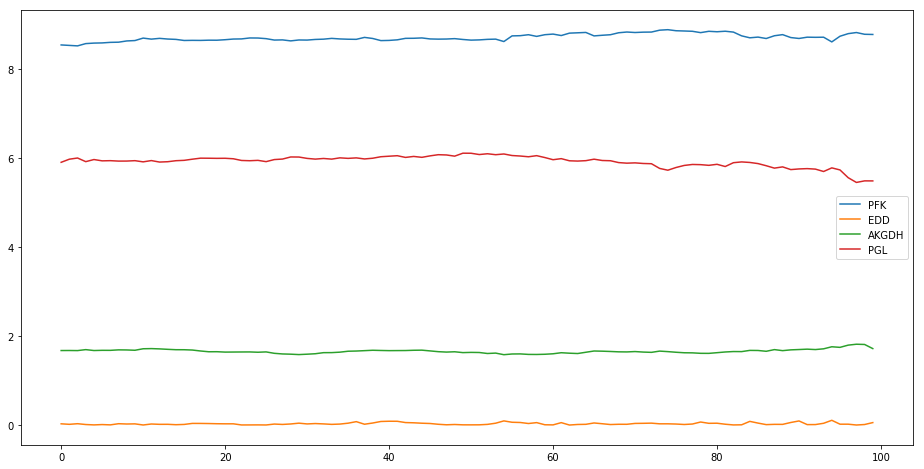

In [105]:
# inspect mixing in the warmup samples
realSamples[allRxns].plot()

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


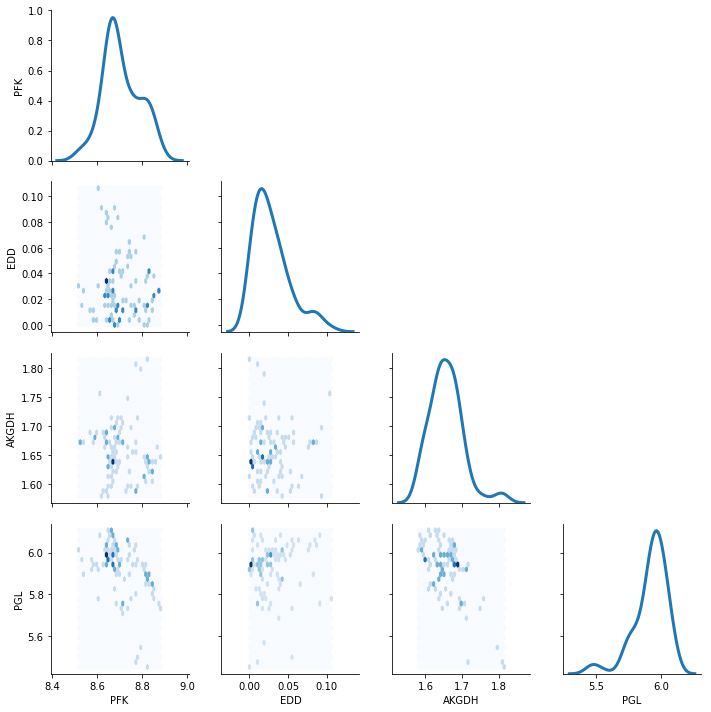

In [106]:
# plot sample distribution for samples
g = sns.PairGrid(realSamples[allRxns], diag_sharey=False)
g.map_lower(plt.hexbin, gridsize=25, cmap=plt.get_cmap('Blues'), linewidths=0)
g.map_diag(sns.kdeplot, lw=3, gridsize=100)
for i, j in zip(*np.triu_indices_from(g.axes, 1)):
    g.axes[i, j].set_visible(False)

In [107]:
# summarize the samples to be plotted

deleteStart = 2000
netSamples = np.subtract(realSamples.iloc[deleteStart::1,0::2], realSamples.iloc[deleteStart::1,1::2])
netUniform = np.subtract(warmupSamples.iloc[deleteStart::1,0::2], warmupSamples.iloc[deleteStart::1,1::2])
display(netUniform.shape)
display(netSamples.shape)

(0, 716)

(0, 716)

In [108]:
# remove reactions with no variance, e.g. they cannot carry flux or were fully constrained

rxnsWithVariance = netUniform.std(axis=0) > 0.001
netUniform = netUniform.loc[:,rxnsWithVariance]
netSamples = netSamples.loc[:,rxnsWithVariance]

In [109]:
# plot marginals

cols = 4
rows = math.ceil(netUniform.shape[1]/cols)

matplotlib.rcParams['figure.figsize'] = (16,3)
for j in range(0, rows):
    for k in range(0, cols):
        i = (j*cols) + k
        if i > (netUniform.shape[1] - 1):
            break

        plt.subplot(1, cols, k + 1)
        sns.kdeplot(netUniform.iloc[:,i], lw=2, gridsize=100, color="grey", label="Uniform")
        sns.kdeplot(netSamples.iloc[:,i], lw=4, gridsize=100, color="darkred")


        plt.xlabel("Flux")
        if k == 0:
            plt.ylabel("Probability density")
    plt.show()

### Compare the MDVs between the best sample and the data

In [110]:
# print out the likelihood for the best sample, and compute it's MDVs
highestProbabilitySample = achr.bestSample[1] + 1e-7
display(achr.bestSample[0])
results = bayflux.simulateLabeling(compiledData, highestProbabilitySample, substrateLabelingDict)

-123.15808493514034

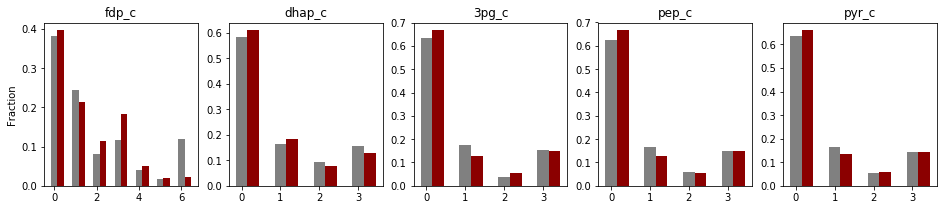

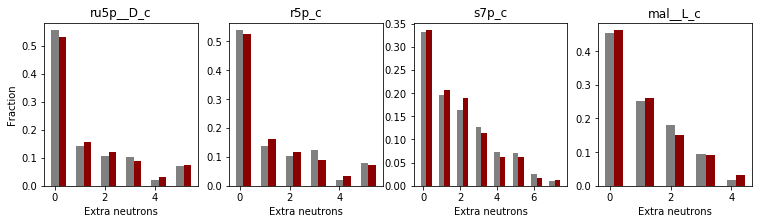

In [111]:
# plot the experimental data (left, grey) against predicted EMUs for the best sample (right, red)

resultsList = list(lcmsResults.items())
cols = 5
rows = math.ceil(len(resultsList)/cols)

for j in range(0, rows):
    for k in range(0, cols):
        i = (j*cols) + k
        if i > len(resultsList) - 1:
            break
        emu, labelingVector = resultsList[i]
        ind = np.arange(len(labelingVector))
        plt.subplot(1, cols, k + 1)
        plt.bar(ind, labelingVector, width=0.3, label=emu.metabolite.id, color="grey")
        plt.title(emu.metabolite.id)
        if j == rows - 1:
            plt.xlabel("Extra neutrons")
        if k == 0:
            plt.ylabel("Fraction")
        for subsize in compiledData:
            objectList = subsize['matrixCoords']['internalEMUs']['hashes']
            if hash(emu) in objectList:
                resultsLabel = results[subsize['size']][objectList.index(hash(emu))]
                plt.bar(ind+0.3, resultsLabel, width=0.3, color="darkred")
    # plt.savefig('test_data/mdv' + str(j) + '.pdf', dpi=400)
    plt.show()

### Check the mean net flux on reactions with guessed transitions flagged as ambiguous

Note: it appears that the only high flux guessed transition is for DHAPT, which is actually correct:
dha_c + pep_c --> dhap_c + pyr_c	abc + def : abc + def

reference: https://biocyc.org/META/NEW-IMAGE?object=2.7.1.121-RXN

In [112]:
netSamples = np.subtract(realSamples.iloc[deleteStart::1,0::2], realSamples.iloc[deleteStart::1,1::2])
meanFluxes = netSamples.mean(axis=0)
meanFluxes[ambiguousNames]

EAR100x   NaN
ADNK1     NaN
KAS15     NaN
DHAPT     NaN
GART      NaN
TRPS3     NaN
PUNP1     NaN
dtype: float64